In [ ]:
%pip install pysentimiento

In [120]:
#Importações
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from pysentimiento import create_analyzer
import seaborn as sns
import matplotlib.pyplot as plt

In [121]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [122]:
# Carregar dados
base_df = pd.read_csv("/content/Impacto da Pandemia no Setor de Tecnologia Pesquisa sobre Condições de Trabalho.csv")

# Selecionar apenas respostas abertas
colunas_texto = base_df.iloc[:, 6:]
respostas = colunas_texto.fillna("").applymap(str).values.flatten()
respostas = [r for r in respostas if r.strip() != ""]

respostas_df = pd.DataFrame(respostas, columns=["registro"])

/tmp/ipython-input-3948602862.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  respostas = colunas_texto.fillna("").applymap(str).values.flatten()


In [123]:
stopwords_pt = set(stopwords.words("portuguese"))
stemmer = SnowballStemmer("portuguese")

def preprocessar(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+", "", texto)
    texto = re.sub(r"[^a-zA-ZÀ-ÿ\s]", " ", texto)
    tokens = word_tokenize(texto)
    tokens = [t for t in tokens if t not in stopwords_pt]
    tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

respostas_df["registro_limpo"] = respostas_df["registro"].apply(preprocessar)

In [124]:
# Rotulagem automática com pysentimiento

analyzer = create_analyzer(task="sentiment", lang="pt")

def classificar_sentimento(texto):
    resultado = analyzer.predict(texto)
    return resultado.output

respostas_df["sentimento"] = respostas_df["registro"].apply(classificar_sentimento)


In [125]:
# Ajustar granularidade

mapeamento = {
    "NEG": "Bem-estar prejudicado",
    "POS": "Bem-estar melhorado",
    "NEU": "Sem impacto percebido"
}
respostas_df["sentimento"] = respostas_df["sentimento"].map(mapeamento)

In [126]:
# Vetorização

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X = vectorizer.fit_transform(respostas_df["registro_limpo"])
y = respostas_df["sentimento"]

In [127]:
# Train-test Split e Oversampling

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

In [128]:
# Modelo

modelo = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
modelo.fit(X_res, y_res)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Relatório de Classificação (conjunto de teste):
                       precision    recall  f1-score   support

  Bem-estar melhorado       0.50      0.10      0.17        10
Bem-estar prejudicado       0.56      0.43      0.49        21
Sem impacto percebido       0.65      0.84      0.73        44

             accuracy                           0.63        75
            macro avg       0.57      0.46      0.46        75
         weighted avg       0.60      0.63      0.59        75



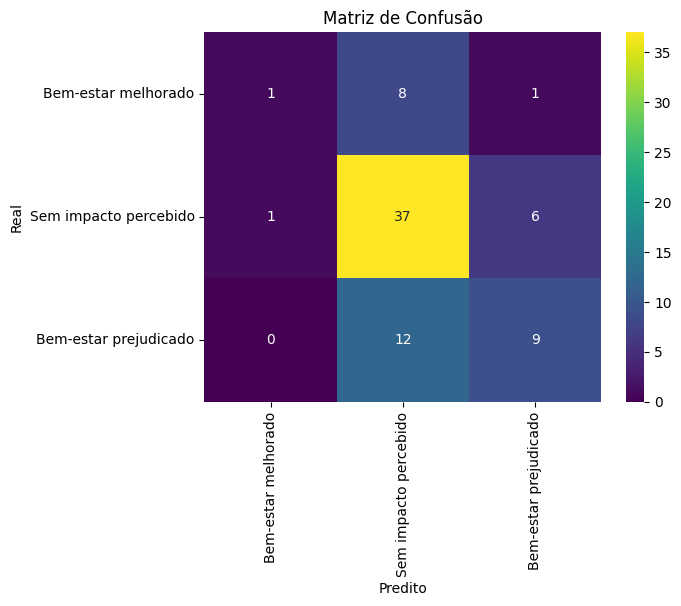

In [129]:
# Avaliação

y_pred = modelo.predict(X_test)

print("Relatório de Classificação (conjunto de teste):")
print(classification_report(y_test, y_pred))

#Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=["Bem-estar melhorado", "Sem impacto percebido", "Bem-estar prejudicado"])
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
            xticklabels=["Bem-estar melhorado", "Sem impacto percebido", "Bem-estar prejudicado"],
            yticklabels=["Bem-estar melhorado", "Sem impacto percebido", "Bem-estar prejudicado"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [130]:
#Cross - validation
scores = cross_val_score(modelo, X, y, cv=5, scoring="accuracy")
print("Acurácias na validação cruzada (5-fold):", scores)
print("Média da acurácia (CV):", scores.mean())

Acurácias na validação cruzada (5-fold): [0.66666667 0.73333333 0.65333333 0.58666667 0.64      ]
Média da acurácia (CV): 0.6559999999999999
